# Data Pipeline

**Contents**
1. Load simulated datasets from `/data`.
2. Apply initial filtering by doing hard cuts by doing Manual filtering/ hard cuts. This will be done on all the datasets, including the simulated acceptance.
3. Train Machine Learning model(s) on the partially filtered datasets
4. Classify and filter the `total_dataset` and `acceptance_mc` based on predictions from the model
5. Off to Fitting group!
   
Last updated 1.3.2022

---

# 1. Load Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
%config InlineBackend.figure_formats = ['svg']

Load total and acceptance datasets

In [47]:
total = pd.read_pickle('data/total_dataset.pkl')
acc = pd.read_pickle('data/acceptance_mc.pkl')

Load simulated datasets and append to one another to create long dataframe with class label. In this case we are doing **binary classification** so the two classes are signal and other i.e. `1` and `0`.

In [48]:
simulations = ['jpsi_mu_k_swap','psi2S','jpsi_mu_pi_swap', 'phimumu', 'pKmumu_piTop',
    'signal','pKmumu_piTok_kTop','k_pi_swap','jpsi']

df = pd.DataFrame()

for file in simulations:
    temp_df = pd.read_pickle('data/' + file + '.pkl')
    if file == 'signal': 
        temp_df["class"] = 1
    else:
        temp_df["class"] = 0
    df = df.append(temp_df, ignore_index=True)

sim = df

# 2. Manual Cuts

In [176]:
%%capture
# Suppress outputs from external file
from FilterPy import q2_cuts, IP_check, mom_check, muon_PT_check, invariant_mass_check, particle_ID_check, check_all

## Cut on the total dataset, acceptance and simulated

This applies the same conditional checks in `cuts`, based on the selections done by the Candidate Finding Group. In addition, it prints out the percentage of the dataframe removed. For the simulated signal dataset in `sim`, since we have the labels, we can know the percentage of signal decay that is kept.

In [50]:
cuts = [q2_cuts, particle_ID_check]

def apply_cuts(df, cuts, verbose= False):
    for cut in cuts:
        df = cut(df)
        if verbose:
            print(df['class'].value_counts()/len(df))
    print('---')
    return df

# Cutting based on all the cuts
print('Total Dataset')
total = apply_cuts(total, cuts)
print('Acceptance')
acc = apply_cuts(acc, cuts)
print('Simulated Dataset')
sim = apply_cuts(sim, cuts, True)

#total = q2_cuts(total)
#acc = q2_cuts(acc)
#sim = q2_cuts(sim)

Total Dataset
percentage dataframe removed = 0.8972553663358388
percentage dataframe removed = 0.9096147835599312
---
Acceptance
percentage dataframe removed = 0.3394530863112551
percentage dataframe removed = 0.17915226210563884
---
Simulated Dataset
percentage dataframe removed = 0.799171778969561
1    0.550193
0    0.449807
Name: class, dtype: float64
percentage dataframe removed = 0.5408190969466605
1    0.98446
0    0.01554
Name: class, dtype: float64
---


In [51]:
len(total), len(acc), len(sim)

(4627, 388687, 131919)

# 3. Machine Learning

Here a Machine Learning model is trained with features in `cols_to_use`, which excludes meaningless columns such as `year`.

Also, we shouldn't cut based on the models we are trying to fit on, namely `phi`, `'costhetal'` and `'costhetak'`.

In [78]:
features = ['mu_plus_MC15TuneV1_ProbNNk', 'mu_plus_MC15TuneV1_ProbNNpi',
       'mu_plus_MC15TuneV1_ProbNNmu', 'mu_plus_MC15TuneV1_ProbNNe',
       'mu_plus_MC15TuneV1_ProbNNp', 'mu_plus_P', 'mu_plus_PT', 'mu_plus_ETA',
       'mu_plus_PHI', 'mu_plus_PE', 'mu_plus_PX', 'mu_plus_PY', 'mu_plus_PZ',
       'mu_plus_IPCHI2_OWNPV', 
       'mu_minus_MC15TuneV1_ProbNNk', 'mu_minus_MC15TuneV1_ProbNNpi', 'mu_minus_MC15TuneV1_ProbNNmu',
       'mu_minus_MC15TuneV1_ProbNNe', 'mu_minus_MC15TuneV1_ProbNNp',
       'mu_minus_P', 'mu_minus_PT', 'mu_minus_ETA', 'mu_minus_PHI',
       'mu_minus_PE', 'mu_minus_PX', 'mu_minus_PY', 'mu_minus_PZ',
       'mu_minus_IPCHI2_OWNPV', 
       'K_MC15TuneV1_ProbNNk', 'K_MC15TuneV1_ProbNNpi', 'K_MC15TuneV1_ProbNNmu',
       'K_MC15TuneV1_ProbNNe', 'K_MC15TuneV1_ProbNNp', 'K_P', 'K_PT', 'K_ETA',
       'K_PHI', 'K_PE', 'K_PX', 'K_PY', 'K_PZ', 'K_IPCHI2_OWNPV',
       'Pi_MC15TuneV1_ProbNNk', 'Pi_MC15TuneV1_ProbNNpi',
       'Pi_MC15TuneV1_ProbNNmu', 'Pi_MC15TuneV1_ProbNNe',
       'Pi_MC15TuneV1_ProbNNp', 'Pi_P', 'Pi_PT', 'Pi_ETA', 'Pi_PHI', 'Pi_PE',
       'Pi_PX', 'Pi_PY', 'Pi_PZ', 'Pi_IPCHI2_OWNPV', 
       'B0_MM', 'B0_ENDVERTEX_CHI2', 'B0_ENDVERTEX_NDOF', 'B0_FDCHI2_OWNPV', 
       'Kstar_MM', 'Kstar_ENDVERTEX_CHI2', 'Kstar_ENDVERTEX_NDOF', 'Kstar_FDCHI2_OWNPV',
       'J_psi_MM', 'J_psi_ENDVERTEX_CHI2', 'J_psi_ENDVERTEX_NDOF',
       'J_psi_FDCHI2_OWNPV', 
       'B0_IPCHI2_OWNPV', 'B0_DIRA_OWNPV', 'B0_OWNPV_X',
       'B0_OWNPV_Y', 'B0_OWNPV_Z', 'B0_FD_OWNPV', 'B0_ID', 'q2']

print('Number of features: ', len(features))

Number of features:  76


In [53]:
# Import machine learning models
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

How many of the other classes are left?

In [54]:
plt.figure(figsize=(6,4))
sim['class'].value_counts()

1    129869
0      2050
Name: class, dtype: int64

<Figure size 1800x1200 with 0 Axes>

## 3.1 Training and Hyperparameter tuning

We want to optimise the models for precision.

In [55]:
# Feature dataset
X = sim[features]
# Labels/ class dataset
y = sim.iloc[:, -1]

# Test train split, in a stratified manner
X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=20, stratify = y)


In [80]:
forest = RandomForestClassifier(n_jobs = 4)
forest.get_params()

Use a grid_search to find the best hyperparameters for the model.

In [81]:
from sklearn.model_selection import GridSearchCV

param_grid = {'n_estimators': [30, 60, 100], 'max_features':[5, 8, 10], 'min_samples_leaf':[1,2,5]}

grid_search = GridSearchCV(estimator=forest,
             param_grid=param_grid, cv=5, scoring='precision', return_train_score=True)

grid_search.fit(X_train, y_train)


GridSearchCV(cv=5, estimator=RandomForestClassifier(n_jobs=4),
             param_grid={'max_features': [5, 8, 10],
                         'min_samples_leaf': [1, 2, 5],
                         'n_estimators': [30, 60, 100]},
             return_train_score=True, scoring='precision')

In [85]:
grid_search.best_params_, grid_search.best_score_

({'max_features': 10, 'min_samples_leaf': 1, 'n_estimators': 60},
 0.9957957331554728)

In [86]:
forest_opt = RandomForestClassifier(verbose=1, n_jobs = 4, max_features=10, n_estimators =60)
forest_opt.fit(X_train, y_train)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   13.1s
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:   18.4s finished


RandomForestClassifier(max_features=10, n_estimators=60, n_jobs=4, verbose=1)

## 3.2 Validation of our model: Confusion matrix
Is our model performing as expected?

By definition a confusion matrix $C$ is such that $C_{i,j}$
is equal to the number of observations known to be in group $i$ and
predicted to be in group $j$.

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


0.9951246435470518


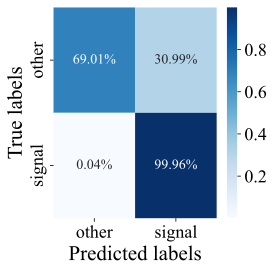

In [75]:
from sklearn.metrics import confusion_matrix 

def validate(model):
    y_valid_pred = model.predict(X_valid)
    cm_forest = confusion_matrix(y_valid, y_valid_pred)

    plt.figure(figsize=(4,4))
    sns.heatmap(cm_forest/cm_forest.sum(keepdims=True, axis=1), annot=True, 
                fmt='.2%', cmap='Blues', xticklabels=['other', 'signal'], yticklabels=['other', 'signal'])

    plt.ylabel('True labels')
    plt.xlabel('Predicted labels')
    plt.tight_layout()

    print(cm_forest[1][1] / (cm_forest[1,1] + cm_forest[0,1]))

validate(forest_opt)

## 3.3 Optimising Decision Thresholds
Since our data is heavily skewed, we should consider precision and recall rather than metrics such as accuracy, true positive rate (TPR) or true negative rate (TNR).

Precision is defined as 

$$\text{Prec} = \frac{\text{TP} }{\text{TP} + \text{FP}}$$

whilst Recall is 

$$\text{Rec} = \frac{\text{TP} }{\text{TP} + \text{FN}}$$

This is helpful as we want to reduce the number of false positives (i.e. non-signal classified as signal).

[0.13333333 0.15       0.16666667 0.18333333 0.2        0.21666667
 0.23333333 0.25       0.26666667 0.28333333 0.3        0.31666667
 0.33333333 0.35       0.36666667 0.38333333 0.4        0.41666667
 0.43333333 0.45       0.46666667 0.48333333 0.5        0.51666667
 0.53333333 0.55       0.56666667 0.58333333 0.6        0.61666667
 0.63333333 0.65       0.66666667 0.68333333 0.7        0.71666667
 0.73333333 0.75       0.76666667 0.78333333 0.8        0.81666667
 0.83333333 0.85       0.86666667 0.88333333 0.9        0.91666667
 0.93333333 0.95       0.96666667 0.98333333 1.        ]


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:    0.1s finished


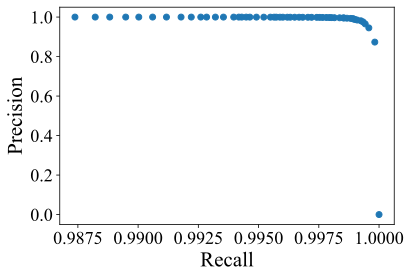

In [93]:
from sklearn.metrics import precision_recall_curve

y_score = forest_opt.predict_proba(X_valid)[:,1]

p, r, thresholds = precision_recall_curve(y_valid, y_score )

plt.figure(figsize=(6,4))
plt.scatter(p,r)
plt.xlabel('Recall')
plt.ylabel('Precision')
print(thresholds)

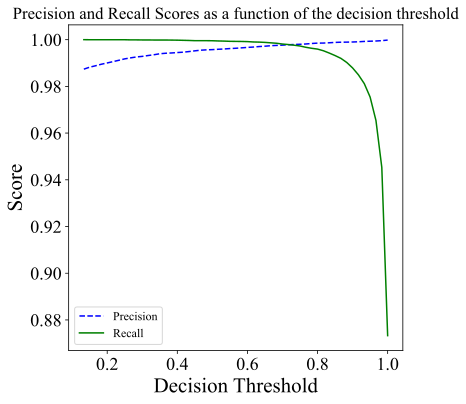

In [90]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    """
    Modified from:
    Hands-On Machine learning with Scikit-Learn
    and TensorFlow; p.89
    """
    plt.figure(figsize=(6, 6))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')

plot_precision_recall_vs_threshold(p,r,thresholds)



Evaluating this model based on a decision threshold of `0.97`.

0.9995766023970818


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:    0.1s finished


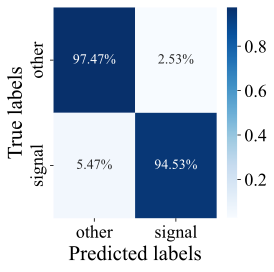

In [175]:
def validate_prob(model, threshold):
    predicted_proba = model.predict_proba(X_valid)
    y_valid_pred = (predicted_proba [:,1] >= threshold).astype('int')

    cm_forest = confusion_matrix(y_valid, y_valid_pred)

    plt.figure(figsize=(4,4))
    sns.heatmap(cm_forest/cm_forest.sum(keepdims=True, axis=1), annot=True, 
                fmt='.2%', cmap='Blues', xticklabels=['other', 'signal'], yticklabels=['other', 'signal'])

    plt.ylabel('True labels')
    plt.xlabel('Predicted labels')
    plt.tight_layout()

    print(cm_forest[1][1] / (cm_forest[1,1] + cm_forest[0,1]))

validate_prob(forest_opt, 0.97)

## 3.4 Train model using all the data
Knowing the appropriate hyperparameters, we can train our model using all the data now.

In [148]:
forest = RandomForestClassifier(max_features=10, n_estimators=60, n_jobs=4,)
forest.fit(X,y)

RandomForestClassifier(max_features=10, n_estimators=60, n_jobs=4)

In [156]:
pickle.dump(forest, open('saved_models/0301_frst.pkl', 'wb'))

# 4. Classification
This part deals with generating the predictions for the `total_dataset`.

We can get a sense of the percentage of data retained by varying the probability threshold for an event to be classified as `signal`.

Text(0, 0.5, 'Percentage of data retained')

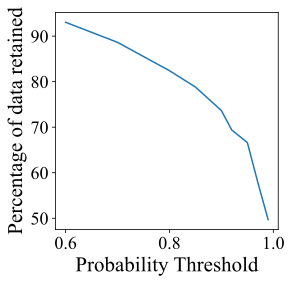

In [152]:
def calculate_retained(df, cols_to_use, model, threshold):
    X = df[cols_to_use]
    
    predicted_proba = model.predict_proba(X)
    y_predict = (predicted_proba [:,1] >= threshold).astype('int')
    df['predictions'] = y_predict
    filtered = df[df['predictions'] == 1]
    return len(filtered)/len(df) *100
    
thresholds = [0.6,0.7,0.8,0.85, 0.9, 0.92,  0.95, 0.97, 0.99]
retained = []
for t in thresholds:
    retained.append(calculate_retained(total, features, forest, t))

plt.figure(figsize=(4,4))
plt.plot(thresholds, retained)
plt.xlabel('Probability Threshold')
plt.ylabel('Percentage of data retained')

In [118]:
def gen_predictions(df, cols_to_use, model, threshold):
    """Drops rows based on its class, which is inferred 
    by Classifying through a Machine Learning model

    Args:
        df (pd.DataFrame): _description_
        cols_to_use (_type_): _description_
        model (sklearn.model): _description_

    Returns:
        filtered (pd.DataFrame): _description_
    """
    X = df[cols_to_use]
    #y_predict = model.predict(X)
    
    predicted_proba = model.predict_proba(X)
    print((predicted_proba [:,1] >= threshold).astype('int'))
    y_predict = (predicted_proba [:,1] >= threshold).astype('int')
    df['predictions'] = y_predict
    filtered = df[df['predictions'] == 1]
    
    print('Percentage of data kept:', len(filtered)/len(df) *100)
    return filtered

In [153]:
filtered = gen_predictions(total, features, forest, threshold=0.97)
acc_filtered = gen_predictions(acc, features, forest, threshold=0.97)


[1 1 0 ... 0 1 1]
Percentage of data kept: 57.94251134644478
[1 1 1 ... 1 1 1]
Percentage of data kept: 93.59510351516774


In [154]:
len(filtered)

2681

## 4.2 Histogram of all variables

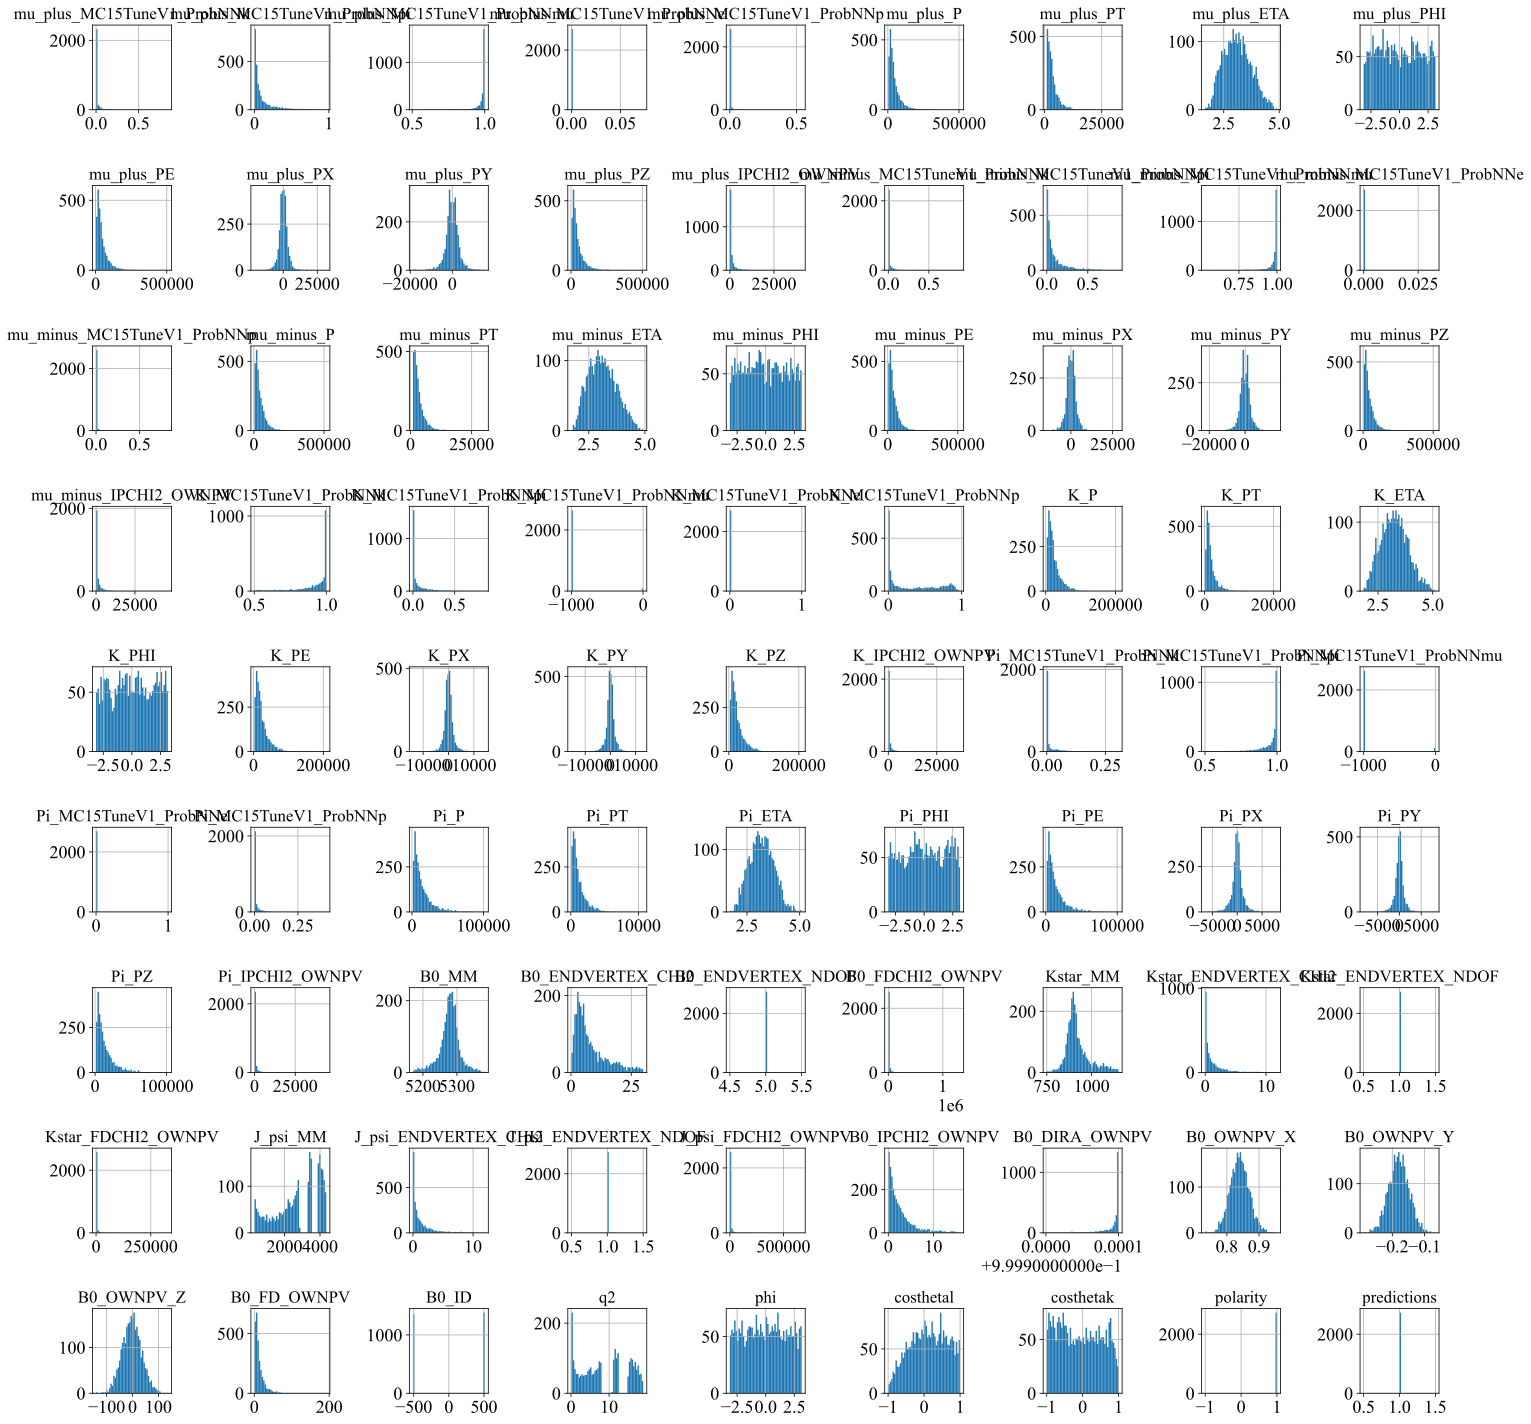

In [147]:
plt.rcParams["figure.figsize"] = (20,20)
plt.rc("figure", dpi=300)
filtered.hist(bins=50)
plt.tight_layout()
plt.show()

# 5. Send to Fitting Group
Output as `.pkl` file with all columns intact and send to the Fitting group for further processing.

In [157]:
pickle.dump(filtered, open('outputs/0301_forest_total.pkl', 'wb'))
pickle.dump(acc_filtered, open('outputs/0301_forest_acc.pkl', 'wb'))